In [2]:
import platform
print('系统:',platform.system())
import time
T1 = time.perf_counter()
import qiskit

系统: Linux


In [3]:
# import warnings; warnings.filterwarnings("ignore")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import op_converter
from qiskit.aqua.operators import WeightedPauliOperator

### Consider the following graph

In [4]:
# design the problem randomly by generating a 2D N*N martix
def Make_Question(n):
    G_ori = np.around(np.random.rand(n, n),decimals=3)
    G_final = G_ori - np.diag(np.diag(G_ori))
    Question =  (G_final + G_final.T)/2
    return Question

In [11]:
# Claim number of vertices
n = 7
Question = np.array(Make_Question(n))
print(Question)

[[0.     0.337  0.7925 0.2995 0.291  0.0375 0.575 ]
 [0.337  0.     0.2205 0.0625 0.7385 0.909  0.539 ]
 [0.7925 0.2205 0.     0.338  0.752  0.6605 0.4905]
 [0.2995 0.0625 0.338  0.     0.6625 0.7825 0.687 ]
 [0.291  0.7385 0.752  0.6625 0.     0.1965 0.403 ]
 [0.0375 0.909  0.6605 0.7825 0.1965 0.     0.132 ]
 [0.575  0.539  0.4905 0.687  0.403  0.132  0.    ]]


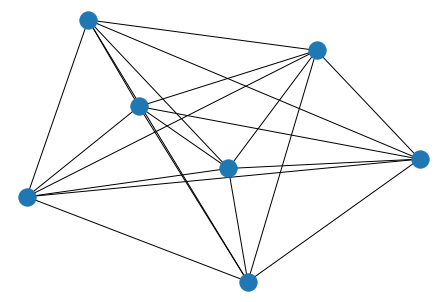

In [12]:
#show the network graph
G = nx.from_numpy_matrix(Question, create_using=nx.MultiGraph)
nx.draw(G)

In [13]:
# show the edge
# G.edges

MultiEdgeView([(0, 1, 0), (0, 2, 0), (0, 3, 0), (0, 4, 0), (0, 5, 0), (0, 6, 0), (1, 2, 0), (1, 3, 0), (1, 4, 0), (1, 5, 0), (1, 6, 0), (2, 3, 0), (2, 4, 0), (2, 5, 0), (2, 6, 0), (3, 4, 0), (3, 5, 0), (3, 6, 0), (4, 5, 0), (4, 6, 0), (5, 6, 0)])

In [14]:
# Another way (Method 1) to design the graph 
# details are in the Dwave .py file

# G = nx.Graph()
# G.add_edges_from([[0,4],[0,5],[0,6],[1,4],[1,5],[2,5],[2,6],[3,5],[3,6]])
# nx.draw(G, pos=nx.bipartite_layout(G, [0,1,2,3]))

In [15]:
#According to the paper, add gates accordingly
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    return qc
    

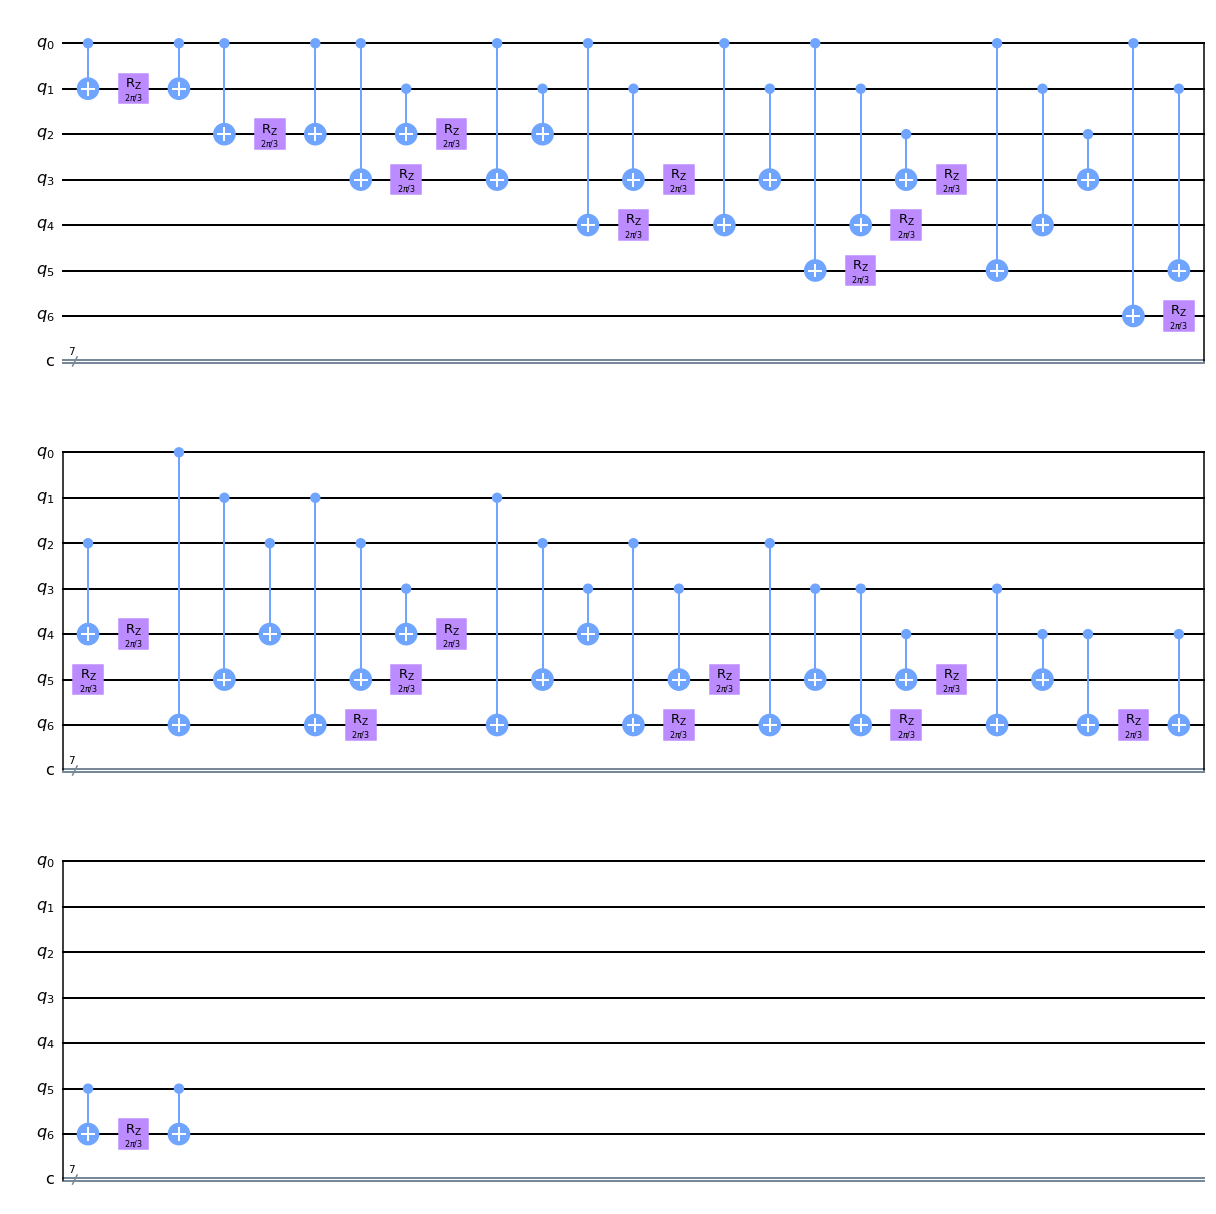

In [16]:
qc = get_cost_operator_circuit(G, np.pi / 3)
qc.draw()

In [17]:
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc

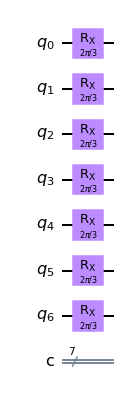

In [18]:
qc = get_mixer_operator_circuit(G, np.pi/3)
qc.draw()

In [19]:
def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G,gamma[i])
        qc += get_mixer_operator_circuit(G,beta[i])
    # finally, do not forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc

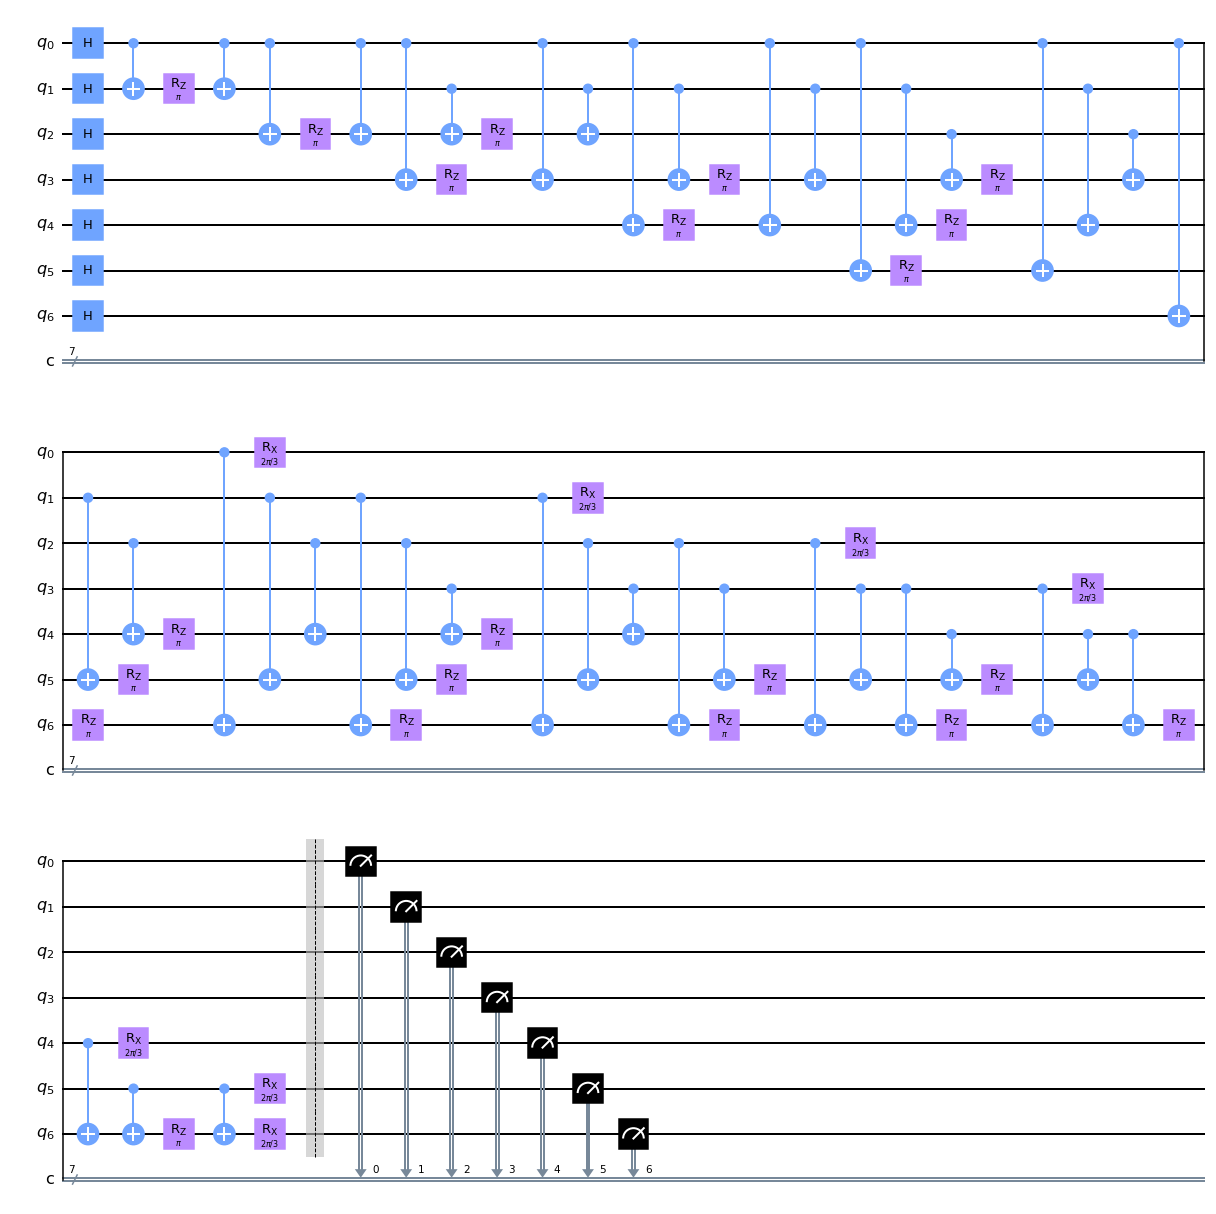

In [20]:
qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])
qc.draw()

In [21]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

In [22]:
backend = Aer.get_backend('qasm_simulator')
T2 =time.perf_counter()

#print('程序运行时间:%s毫秒' % ((T2 - T1)*1000))
# CN -程序运行时间:0.27023641716203606毫秒

print('Program running time:%sms' % ((T2 - T1)*1000))
# EN -Program running time : 0.27023641716203606  ms

job = execute(qc, backend, shots=100000)
result = job.result()
print(invert_counts(result.get_counts()))


程序运行时间:370180.36636617035毫秒
{'0000000': 808, '1000000': 757, '0000100': 732, '1000100': 725, '0100100': 811, '1100100': 774, '0010100': 824, '1010100': 820, '0110100': 787, '1110100': 756, '0001100': 758, '1001100': 769, '0101100': 843, '1101100': 828, '0011100': 753, '1011100': 793, '0111100': 747, '1111100': 732, '0100000': 808, '0000010': 780, '1000010': 795, '0100010': 752, '1100010': 814, '0010010': 751, '1010010': 780, '0110010': 763, '1110010': 812, '0001010': 782, '1001010': 795, '0101010': 767, '1101010': 795, '0011010': 815, '1011010': 810, '0111010': 756, '1111010': 857, '1100000': 771, '0000110': 763, '1000110': 764, '0100110': 773, '1100110': 808, '0010110': 820, '1010110': 769, '0110110': 786, '1110110': 767, '0001110': 716, '1001110': 777, '0101110': 828, '1101110': 816, '0011110': 811, '1011110': 757, '0111110': 786, '1111110': 806, '0010000': 736, '0000001': 793, '1000001': 766, '0100001': 756, '1100001': 758, '0010001': 796, '1010001': 812, '0110001': 772, '1110001': 

In [23]:
#check how many time of mearsurement we have done 
output = invert_counts(result.get_counts())
sum(output.values())

100000

In [24]:
#Cost function
def maxcut_obj(x,G,Question):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            print(i,j)
            try:
                cut -= Question[i,j]
            except:
                cut -= Question[j,i]
    return cut
demo_x = np.random.randint(2, size=n)
maxcut_obj(demo_x, G, Question)

[1 1 0 1 0 1 0]
0 2
0 4
0 6
1 2
1 4
1 6
2 3
2 5
3 4
3 6
4 5
5 6


-5.833

In [213]:
# How to build cost function related to (Method 1)
#def maxcut_obj(x,G):
#    cut = 0
#    problem = {'Z0 Z4':0.73,'Z0 Z5':0.33,'Z0 Z6':0.5,'Z1 Z4':0.69,'Z1 Z5':0.36,
#           'Z2 Z5':0.88,'Z2 Z6':0.58,'Z3 Z5':0.67,'Z3 Z6':0.43}
#    for i, j in G.edges():
#        if x[i] != x[j]:
#            # the edge is cut
#            try:
#                cut -= problem['Z%d Z%d'%(j,i)]
#            except:
#                cut -= problem['Z%d Z%d'%(i,j)]
#    return cut

#maxcut_obj('0000111', G)

In [214]:
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G, Question)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_maxcut_energy(invert_counts(result.get_counts()), G)

-22.588817024999997

In [215]:
def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)
        counts = execute(qc, backend, seed_simulator=10,shots=100000,optimization_level = 3).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

In [216]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 10000 
# maxiter goes high when problem is complex
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':10000, 'disp': True})
res_sample

     fun: -22.94228541000002
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 137
  status: 1
 success: True
       x: array([-0.02611451,  3.57697112,  1.46191411,  2.88561723,  1.33436614,
        3.05617887,  4.84189981,  3.35653063,  3.79953258,  6.35259984])

In [217]:
#show the sample result (shot is the total number of measurement)
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend,shots=100000).result().get_counts())
counts

{'00000000000000': 192,
 '10000000000000': 2,
 '00001000000000': 1,
 '00000000100000': 3,
 '00000000000010': 2,
 '10000000000010': 3,
 '01000000000010': 1,
 '11000000000010': 7,
 '00100000000010': 2,
 '10100000000010': 9,
 '01100000000010': 10,
 '11100000000010': 3,
 '00010000000010': 1,
 '10010000000010': 7,
 '01010000000010': 9,
 '11010000000010': 3,
 '00110000000010': 8,
 '10110000000010': 5,
 '01110000000010': 4,
 '11110000000010': 5,
 '10000000100000': 1,
 '10001000000010': 6,
 '01001000000010': 8,
 '11001000000010': 3,
 '00101000000010': 3,
 '01101000000010': 3,
 '11101000000010': 4,
 '00011000000010': 4,
 '10011000000010': 1,
 '01011000000010': 1,
 '11011000000010': 2,
 '00111000000010': 3,
 '10111000000010': 4,
 '01111000000010': 4,
 '11111000000010': 8,
 '01000000100000': 1,
 '10000100000010': 9,
 '01000100000010': 4,
 '11000100000010': 2,
 '00100100000010': 6,
 '10100100000010': 4,
 '01100100000010': 3,
 '11100100000010': 3,
 '00010100000010': 9,
 '10010100000010': 3,
 '01010

In [218]:
q_candidate = []
q_occurance = []
q_result = counts.keys()
for item in q_result:
    q_candidate.append(item)
    q_occurance.append(counts[item])

In [219]:
# max occurance usually the optimal answer
print(max(q_occurance))
# Average occurance
print(sum(q_occurance)/len(q_occurance))

192
6.396724876863046


In [220]:
#plt.figure(figsize = (6,100))
#plt.barh(q_candidate, q_occurance, height=0.5, align='center')
#plt.grid(True)
#plt.xlabel('Occurance')

<StemContainer object of 3 artists>

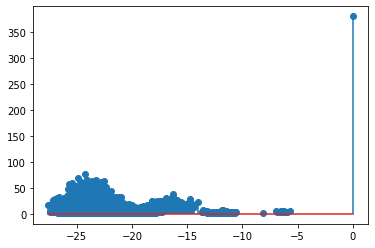

In [221]:
#Energy distribution
energies = defaultdict(int)
for k, v in counts.items():
    energies[maxcut_obj(k,G,Question)] += v

x,y = zip(*energies.items())
plt.stem(x,y)

Best string: 10101001000110 with cut: 27.576500000000006


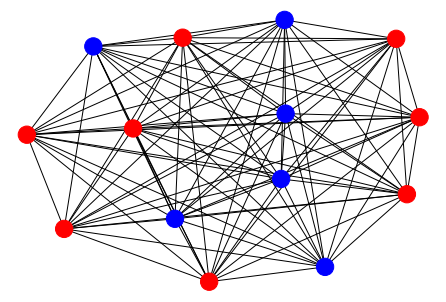

In [222]:
# get the best solution:
best_cut, best_solution = min([(maxcut_obj(x,G,Question),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors)

In [223]:
#show the position in the complex plane.
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
sv = execute(qc, backend=Aer.get_backend('statevector_simulator'),shots=100000).result().get_statevector()
sv

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

In [224]:
#timer
T3 =time.perf_counter()
print('程序运行时间:%s毫秒' % ((T3 - T2)*1000))
# 程序运行时间:0.27023641716203606毫秒

程序运行时间:530092.8600253537毫秒
